### MOOC-HPFEM: Template notebook to be used to complete the assignments



The present notebook is meant to be a template for you to use while doing the assignments of the course. The first cell is meant to be run as-is and takes care of configuring the environment for you. The second cell is empty by default and is where you are supposed to paste the code you are given in the assignments so that you can modify and run it.

### FEniCS DFS formulation to run and modify yourself

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *


import matplotlib.pyplot as plt
from IPython.display import clear_output, display, update_display
import time
import dolfin.common.plotting as fenicsplot 
import numpy as np 
import logging ; 
logging.getLogger('FFC').setLevel(logging.WARNING) 
set_log_active(False)

# Compact plot utility function
def plot_compact(u, t, stepcounter): 
    if stepcounter % 2.5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); 
        ax.cla(); 
        fig = plt.gcf(); 
        fig.set_size_inches(16, 2)

        # Plot norm of velocity
        ax1 = plt.subplot(1, 2, 1);
        pp = plot(uEuclidnorm); 
        plt.title("Velocity")

        if t == 0.: 
           plt.colorbar(pp); 
           plt.axis(G)

        plt.subplot(1, 2, 2);

        if t == 0.:
           plot(Q.mesh()) 
           plt.title("Mesh") # Plot mesh
        display(pl)

        plt.suptitle("Navier-Stokes t: %f" % (t));
        plt.tight_layout();
        clear_output(wait=True);

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G); plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)



elapsed CPU time: 111.869836 
0.0


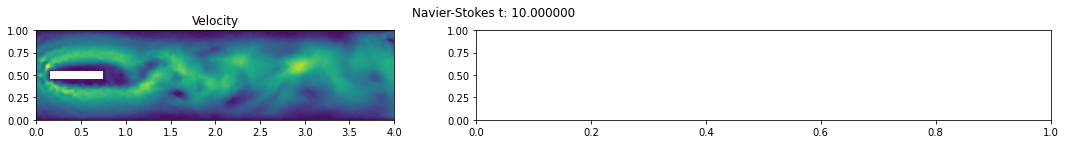

In [67]:
# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

mresolution=50
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Rectangle(Point(0.15,0.45),Point(.75,.55)), mresolution)

# FEM function spaces and functions
Ve = VectorElement("CG", mesh.ufl_cell(), 1)
Qe = FiniteElement("CG", mesh.ufl_cell(), 1)
Q = FunctionSpace(mesh, Qe)
V = VectorFunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, Ve * Qe)
h = CellDiameter(mesh) 
(v, q) = TestFunctions(W);
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX,degree=2) 

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps,degree=2) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps,degree=2)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps,degree=2)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
nu = 1e-6; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = plt.subplots(); 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

print ("elapsed CPU time: %f " %(time.clock() - timer0))
n = FacetNormal(mesh)
psimarker = Expression("pow((x[0]-0.5),2) + pow((x[1]-0.5),2) < pow(0.1,2)+eps" , eps = eps , degree=2) 
M1 = psimarker*p*n[0]*ds # Drag (only pressure)
drag_force = assemble(M1)
print(drag_force)

In [0]:
? generate_mesh